In [1]:
import os
import glob

import sys
sys.path.append('.')
sys.path.append('../')
sys.path.append("neuroformer")
# sys.path.append('/home/antonis/projects/slab/git/neuroformer/neuroformer')

import pandas as pd
import numpy as np

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from attentionVis import AttentionVis
from model_perceiver import GPT, GPTConfig
from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
import skimage
import skvideo.io
from utils import print_full

import matplotlib.pyplot as plt
from utils import set_plot_params
set_plot_params()
%matplotlib inline
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

In [2]:
from utils import set_seed
set_seed(25)

In [3]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

stim_folder = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli"
im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

train_path = "/content/stimulus"
train_path = "/Users/antonis/Downloads/OneCombo3/stimuli"
video_stack = [skimage.io.imread(stim_folder + vid) for vid in im_path]
print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

[]
im_sack size: torch.Size([5760, 1, 64, 112])


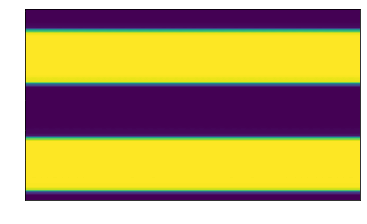

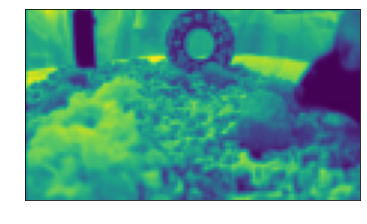

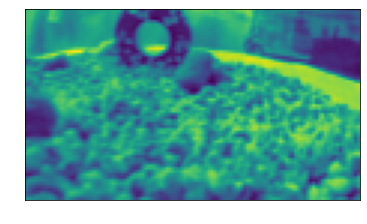

In [4]:
plt.figure()
plt.imshow(video_stack[0, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[1, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[2, 1].permute(1, 2, 0))

In [5]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [6]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

In [7]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
dt_range = int(window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(3)

In [8]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
df.groupby(['Interval', 'Trial']).size().nlargest(100)

Interval  Trial
18.5      42       49
4.5       45       36
26.0      49       35
29.0      26       35
4.0       23       33
                   ..
          29       21
          33       21
4.5       22       21
7.0       13       21
7.5       7        21
Length: 100, dtype: int64

In [9]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 52
id_block_size = 52   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [10]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(df['Trial'].max() // 20):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [11]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)
dataset = SpikeTimeVidData2(df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}')

Length: 25612 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 20449 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 5163 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 393 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
train: 2941


In [12]:
def get_class_weights(dataset):
  dt = []
  id = []
  for x, y in dataset:
    id.extend([stoi['SOS']] + y['id'][:len(y['id']) - x['pad']].flatten().tolist() + [stoi['PAD']]) # -1 in pad to include PAD token
    dt.extend([stoi_dt[0]] + y['dt'][:len(y['dt']) - x['pad']].flatten().tolist() + [dataset.dt_max]) # -1 in pad to include PAD token

  id = pd.DataFrame(id)
  dt = pd.DataFrame(dt)

  id_freq = id.groupby([0]).size()
  dt_freq = dt.groupby([0]).size()

  id_ones = np.ones(dataset.id_population_size)
  dt_ones = np.ones(dataset.dt_population_size)

  id_ones[id_freq.index] = (1 / id_freq) * id_freq.max() / id_freq.max()
  dt_ones[dt_freq.index] = (1 / dt_freq) * dt_freq.max() / dt_freq.max()
  
  class_freq = dict()
  class_freq['id'] = torch.tensor(id_ones, dtype=torch.float32)
  class_freq['dt'] = torch.tensor(dt_ones, dtype=torch.float32)
  
  return class_freq 

class_weights = get_class_weights(train_dataset)

In [13]:
from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=False,
                        n_state_layers=6, n_state_history_layers=6, n_stimulus_layers=6,
                        n_layer=8, n_head=8, n_embd=256,
                        temp_emb=True, pos_emb= True,
                        id_drop=0.1, im_drop=0.1)
model = GPT(mconf)
device = torch.cuda.current_device if torch.cuda.is_available else 'cpu'
model_path = "/home/antonis/projects/slab/git/neuroformer/models/neuroformer_norm_weighted:dt_:True_perceiver_2.0_0.05_(6, 6, 6)_8_256.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [320]:
def att_interval(model, module, loader, n_blocks, block_size, pad_key=None):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    T = block_size
    attention_scores = None
    data = dataset
    pbar = tqdm(enumerate(loader), total=len(loader))
    atts = np.zeros(frame_block_size)
    for it, (x, y) in pbar:
        pad = x[pad_key] if pad_key is not None else 0
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # forward the model
        _, _, _, = model(x)
        # scores = np.array(np.zeros(len(neurons)))
        # att = np.zeros(len(feat_encodings))
        score = AttentionVis.get_attention(module, n_blocks, T, pad)
        # att_dict = dict()
        # for n, step in enumerate(score[frame_block_size:]):
        #     step = step[:frame_block_size]
        if attention_scores is None:
                attention_scores = score[None, ...]
        else:
            attention_scores = np.vstack((attention_scores, score[None, ...]))

            # att_dict[int(y['id'][:, n])] = step
        # atts[tuple(x['interval'].cpu().numpy().flatten())] = att_dict
    return attention_scores
        # take attentions from last step

In [184]:
def att_models(model, module, loader, n_blocks, block_size, pad_key=None):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    T = block_size
    attention_scores = np.zeros(mconf.id_vocab_size)
    pbar = tqdm(enumerate(loader), total=len(loader))
    for it, (x, y) in pbar:
        pad = x[pad_key] if pad_key is not None else 0
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # forward model to calculate attentions
        _, _, _ = model(x)
        # scores = np.array(np.zeros(len(neurons)))
        att = np.zeros(len(feat_encodings))
        score = AttentionVis.get_attention(module, n_blocks, T, pad)
        score = np.sum(score, axis=-2)
        # take attentions from last step
        # if score.size >= 1: score = score[-1]
        # scores.append(score)
        real_ids = x['id'][:, :T - pad].flatten()
        for idx, code in enumerate(real_ids):
            """ 
            for each code in scores,
            add its score to the array
            """
            code = int(code.item())
            att[code] += score[idx]
        attention_scores = np.vstack((attention_scores, att))
    return attention_scores.sum(axis=0)

In [321]:
loader = DataLoader(dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# iterable = iter(loader)
# x, y = next(iterable)

In [322]:
x['pad']

tensor([33])

In [264]:
# x, y = next(iterable)
# model = model.to('cpu')
# _, _, _ = model(x)

In [323]:
from attentionVis import AttentionVis

# attt = model.neural_visual_transformer.neural_state_stimulus
# stim_att = AttentionVis.get_attention(model.neural_visual_transformer.neural_state_stimulus, 6, id_block_size, x['pad'])

In [326]:
# state_atts = att_models(model, model.neural_visual_transformer.neural_state_block, loader, model.config.n_state_layers, 'pad')
# history_atts = att_models(model, model.neural_visual_transformer.neural_state_history_block, loader, model.config.n_state_history_layers, 'pad_prev')
stimulus_atts = att_interval(model, model.neural_visual_transformer.neural_state_stimulus,
                             loader, model.config.n_stimulus_layers, mconf.id_block_size, 'pad')

100%|██████████| 3670/3670 [15:49<00:00,  3.87it/s]


In [331]:
att_trials_id = stimulus_atts[:,]
att_trials_id_std = np.std(att_trials_id, axis=-1)

vid_stack = video_stack.view(3, video_stack.shape[1], video_stack.shape[3], video_stack.shape[4], video_stack.shape[2])
print(vid_stack.shape)

torch.Size([3, 640, 64, 112, 1])


In [332]:
sorted_att_std = np.unravel_index(np.argsort(-att_trials_id_std.ravel()), att_trials_id_std.shape)
head, row, col = sorted_att_std
top_n = 100
att_std_idx = head[(top_n - 1)], row[(top_n - 1)], col[(top_n - 1)]
att_top_std = att_trials_id[att_std_idx]
att_top_std = F.softmax(torch.tensor(att_top_std), dim=-1).numpy()
att_top_std_im = att_top_std.reshape(1, 20, 4, 7)
att_top_std_im = att_top_std_im[-1, -1, :, :]

In [334]:
# state_att = state_atts[df['ID'].unique()] / df.groupby(['ID']).size()
# history_att = history_atts[df['ID'].unique()] / df.groupby(['ID']).size()
# total_att = state_att + history_att / 2

In [335]:
def heatmap2d(arr: np.ndarray, alpha=0.5):
    ncolors = 256
    color_array = plt.get_cmap('viridis')(range(ncolors))

    # change alpha values
    n = 20
    color_array[:,-1] = [0.0] * n +  np.linspace(0.0,1.0,(ncolors - n)).tolist()

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

    # register this new colormap with matplotlib
    # plt.clim(0, 1)
    plt.register_cmap(cmap=map_object)
    arr = gaussian_filter(arr, sigma=3.5)
    h = plt.imshow(arr, cmap='rainbow_alpha', alpha=alpha)
    # plt.colorbar()
    # plt.clim(0, 1)
    # plt.colorbar(mappable=h)

<ipython-input-335-2b47fbbfa142>:14: UserWarning: Trying to register the cmap 'rainbow_alpha' which already exists.
  plt.register_cmap(cmap=map_object)


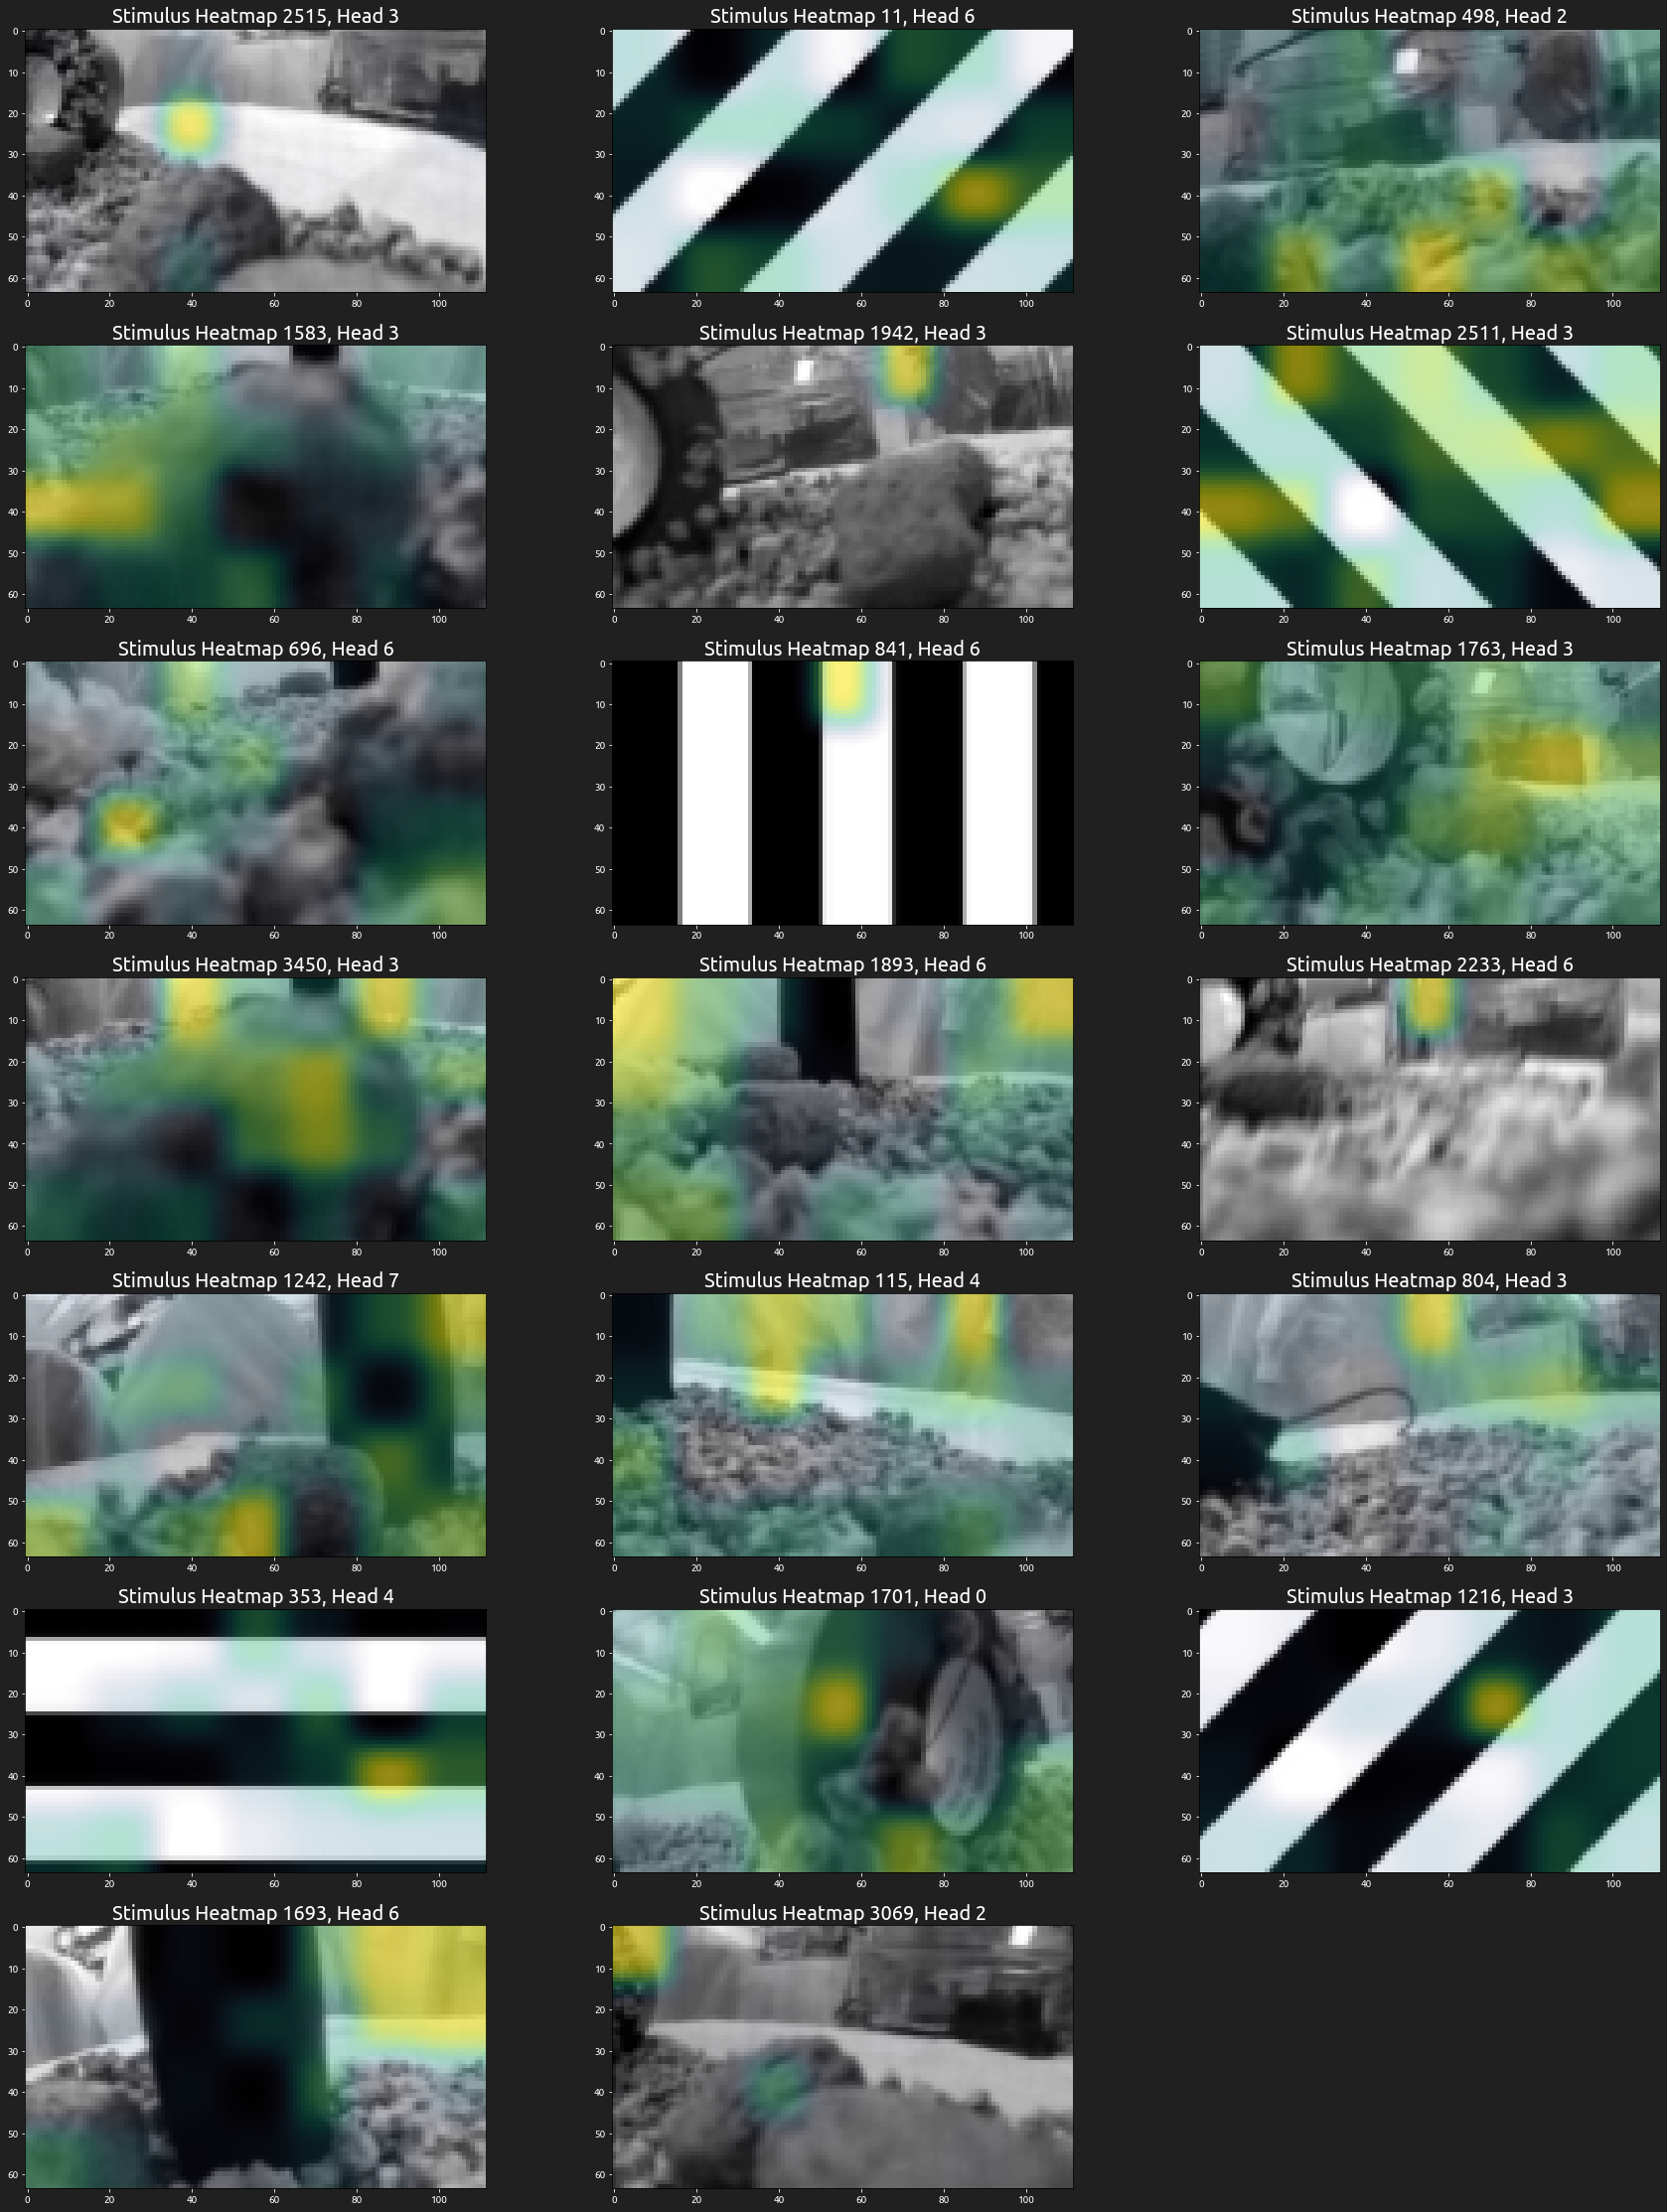

In [402]:
from utils import set_plot_white, set_plot_black
set_plot_black()
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import softmax

# ix_step = [1, 2, 3, 4]
ix_step = np.random.choice(len(stimulus_atts), 20)
ncol = 3
nrow = len(ix_step) // ncol + 1
plt.figure(figsize=(30, 40))

sorted_att_std = np.unravel_index(np.argsort(-att_trials_id_std.ravel()), att_trials_id_std.shape)
row, head, col = sorted_att_std
for n, ix in enumerate(ix_step):
    top_n = ix
    att_std_idx = row[(top_n - 1)], head[(top_n - 1)], col[(top_n - 1)]
    att_top_std = att_trials_id[att_std_idx]
    att_top_std = F.softmax(torch.tensor(att_top_std), dim=-1).numpy()
    att_top_std_im = att_top_std.reshape(1, 20, 4, 7)
    att_top_std_im = att_top_std_im[-1, -1, :, :]

    t = df.groupby(['Interval', 'Trial']).size().reset_index().iloc[att_std_idx[0]]
    if t['Trial'] <= 20: n_stim = 0
    elif t['Trial'] <= 40: n_stim = 1
    elif t['Trial'] <= 60: n_stim = 2  

    # print(n_stim, math.ceil(t['Interval'] * 20))
    im_interval = vid_stack[n_stim, math.ceil(t['Interval'] * 20) - 1]

    att_grid =  softmax(att_top_std_im / att_top_std_im.max())
    att_grid = np.repeat(att_grid, (128 // 8), axis=0)
    att_grid = np.repeat(att_grid, (128 // 8), axis=1)

    plt.subplot(nrow, ncol, n+1)
    # im_interval = gaussian_filter(im_interval, sigma=1)
    plt.imshow(im_interval, cmap='gray')
    heatmap2d(att_grid, alpha=0.6)
    plt.title(f'Stimulus Heatmap {ix}, Head {head[(top_n - 1)]}', fontsize=20)




In [ ]:
943, 3
